# Fast exponential and softmax functions

Based on the bit manupulation of the IEEE 754 floating point numbers.
See N. N. Schraudolph, “A Fast, Compact Approximation of the Exponential Function,” Neural Computation, vol. 11, no. 4, pp. 853–862, May 1999, doi: 10.1162/089976699300016467.

A 32-bit floating point number is given by:
$$ x = (-1)^s (1+m)2^{e-127} $$
where $s$ - sign bit; $m$ - 23-bit mantissa; $e$ - 8-bit exponent;

For bit layout see [this diagram](https://upload.wikimedia.org/wikipedia/commons/d/d2/Float_example.svg).

Writing some integer value $i$ in bit field of the exponent and read back as a float number will give value of$2^{i-127}$. 

So dividing $x$ by dividing by $\ln(2)$, shifting the value $x/\ln(2)+127$ by 23 bit, and reading back the bits of resulting integer number as a flot will give value of the $e^x$. Correction factor $C$ allows adjusting the approximation for some parameters.

$$f(x) = 2^{23} \left(\frac{x}{\ln(2)} + 127 - C\right)$$
In some example following approximation is used with specific values in code $C = 0.057985$:
```C
uint32_t value = (1<<23)*(1.4426950409*x+126.94201519f);
```
Which is then bitcast to floating point number via union type punning.


## Softmax

Softmax is a function over a vector $\mathbf{X}$:

$$ \sigma(\mathbf{X})_i = \frac{e^{x_i}}{\sum\limits_{j=0}^{N}e^{x_j}} $$


When calculating softmax the maximum is substracted from initial data for numerical stability - to avoid overflows.

## Further reading

F. Perini and R. D. Reitz, “Fast approximations of exponential and logarithm functions combined with efficient storage/retrieval for combustion kinetics calculations,” Combustion and Flame, vol. 194, pp. 37–51, 2018, doi: 10.1016/j.combustflame.2018.04.013.

J.-M. Muller, “Elementary Functions and Approximate Computing,” Proc. IEEE, vol. 108, no. 12, pp. 2136–2149, 2020, doi: 10.1109/JPROC.2020.2991885.





C = 0.057985
0.6931471805599453
A: 12102203.0
C: 1064866816.0
f64 A: 1048576.0/ln(2) = 1512775.4
f64 C: 1072693248.0-60801.0=1072632448.0
Upper bound: 2.000000
Lower bound: 4435613.826217
Lowest maximum relative error: gamma = 0.030275
Lowest maximum relative error: c = 366392.997292 0.043677
Lowest RMS error: c = 486411.880684 0.057985
Lowest mean error: c = 545947.460827 0.065082
exp
True                      | max err = 0.000000 | rms err = 0.000000 
fast_exp                  | max err = 3.938597 | rms err = 1.760405 
int_fast_exp_rem          | max err = 3.893035 | rms err = 1.950529 
perini_fast_exp_simple    | max err = 0.000054 | rms err = 0.000016 
perini_fast_exp_cubic     | max err = 0.048481 | rms err = 0.029319 
softmax
True                      | max err = 0.000000 | rms err = 0.000000 
fast_exp                  | max err = 3.947989 | rms err = 1.760435 
int_fast_exp_rem          | max err = 5.334530 | rms err = 2.394726 
perini_fast_exp_simple    | max err = 0.000060 | rm

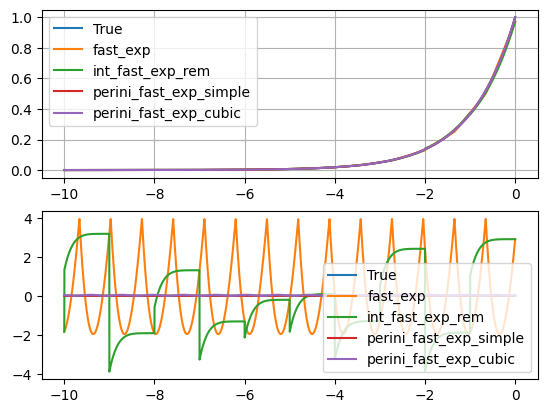

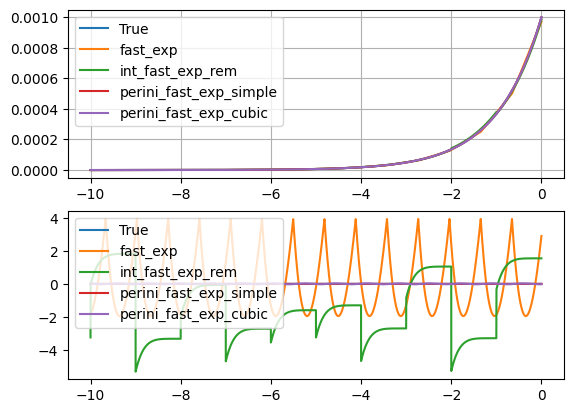

In [41]:
import numpy as np
from matplotlib import pyplot as plt
from functools import partial

SIZE = 10000

C = 127 - 126.94201519
LOG2_e = np.float32(1.4426950409)

print("C = {:f}".format(C))
print(1 / np.log2(np.e))

print("A: {:0.1f}".format(LOG2_e * np.float32(1 << 23)))
print("C: {:0.1f}".format(np.float32(126.94201519) * np.float32(1 << 23)))

print("f64 A: {:0.1f}/ln(2) = {:0.1f}".format(np.float64(1 << 20), LN2 * np.float64(1 << 20)))
print("f64 C: {:0.1f}-{:0.1f}={:0.1f}".format(1023 * np.float32(1 << 20), 60801, 1023 * np.float32(1 << 20) - 60801))


def fast_exp(x, c=C):
    A = LOG2_e * np.ones((SIZE), np.float32)
    K = np.float32(1 << 23) * np.ones((SIZE), np.float32)
    y = np.multiply(K, (A * x + 127 - c), dtype="f")
    z = np.int32(y)
    v = z.view(np.float32)
    return v

def f64_fast_exp(x):
    A = np.float64((1 << 20) * LOG2_e) * np.ones((SIZE), np.float64)
    C = 60801
    y = (A * np.float64(x) + 1072693248 - C)
    z = np.int64(y) << 32
    v = z.view(np.float64)
    return v

def perini_cubic_delta_yf(yf):
    s0 = np.float32(0)
    s1 = np.float32(0.30758037765820823 )
    s2 = np.float32(-0.23141283591588344 )
    s3 = np.float32(-7.6167541742324804e-2)
    return s1 * yf + s2 * yf * yf + s3 * yf * yf * yf

def perini_taylor(yf):
    return 1 + yf - 2**yf

def perini_fast_exp(x, corr):
    y = np.float32(x * LOG2_e)
    yf = y - np.int32(y) + 1 # y < 0
    y2 = np.int32((1 << 23) * (y - corr(yf) + 127))
    return y2.view(np.float32)


def int_fast_exp(x):
    A = np.int32(12102203)
    C = np.int32(1064866816)
    v = np.int32(x) * A + C
    return v.view(np.float32)


def taylor_exp(x, q=5):
    result = 1
    el = result
    for i in range(1, q):
        el = el * x / i
        result = result + el
    return result


def int_exp_rem(x, int_exp_func, rem_exp_func):
    intp = np.int32(x)
    rem = x - intp
    y = int_exp_func(intp) * rem_exp_func(rem)
    return np.float32(y)


def fast_log(x):
    sigma = 0.0430357
    v = x.view(np.int32)
    y = 0.6931471805599453 * np.float32(v / (2**23) - (127 - sigma))
    return np.float32(y)


def fast_exp_newtons(x, exp_func, log_func, q=1):
    y = exp_func(x)
    for _ in range(q):
        y = y - y * log_func(y) + y * x
    return y


def bounds():
    print("Upper bound: {:f}".format(fast_exp([0], -1)[0]))
    print(
        "Lower bound: {:f}".format(2**23 * ((1 - (np.log(np.log(2)) + 1)) / np.log(2)))
    )
    gamma = np.log(np.log(2) + 2 / np.e) - np.log(2) - np.log(np.log(2))
    c = gamma * 2**23 / np.log(2)
    print("Lowest maximum relative error: gamma = {:f}".format(gamma))
    print("Lowest maximum relative error: c = {:f} {:f}".format(c, c / 2**23))
    c = np.log(3 / (8 * np.log(2)) + 0.5) / np.log(2)
    print("Lowest RMS error: c = {:f} {:f}".format(2**23 * c, c))
    gamma = 0.045111411
    c = gamma / np.log(2)
    print("Lowest mean error: c = {:f} {:f}".format(2**23 * c, c))


def softmax(x, func):
    exps = func(x)
    sums = np.sum(exps)
    return func(x) / sums


def get_err(x, tr, app):
    return 100 * (tr(x) - app(x)) / tr(x)


def plot(x, funcs, labels):
    fig, (ax1, ax2) = plt.subplots(2, 1)
    ax1.grid(True)
    i = 0
    for func in funcs:
        ax1.plot(x, func(x))
        err = get_err(x, funcs[0], func)
        ax2.plot(x, err)
        print(
            "{:25s} | max err = {:f} | rms err = {:f} ".format(
                labels[i], max(np.abs(err)), np.sqrt(np.mean(err**2))
            )
        )
        i = i + 1
    ax1.legend(labels)
    ax2.legend(labels)


bounds()

x = np.linspace(-10, 0.0, SIZE, dtype=np.float32)
print("exp")
int_fast_exp_rem = partial(
    int_exp_rem, int_exp_func=int_fast_exp, rem_exp_func=taylor_exp
)
int_fast_exp_fast = partial(
    int_exp_rem, int_exp_func=int_fast_exp, rem_exp_func=fast_exp
)
int_fast_exp_rem_lut = partial(
    int_exp_rem, int_exp_func=np.exp, rem_exp_func=taylor_exp
)
int_fast_exp_fast_lut = partial(int_exp_rem, int_exp_func=np.exp, rem_exp_func=fast_exp)
fast_exp_newtons_fast = partial(fast_exp_newtons, exp_func=fast_exp, log_func=fast_log)
fast_exp_newtons_int = partial(
    fast_exp_newtons, exp_func=int_fast_exp_rem, log_func=fast_log
)
perini_fast_exp_cubic = partial(perini_fast_exp, corr=perini_cubic_delta_yf)
perini_fast_exp_simple = partial(perini_fast_exp, corr=perini_taylor)
def fast_exp_taylor(x):
    return fast_exp(x) * taylor_exp(x - np.int32(x))
plot(
    x,
    [
        np.exp,
        fast_exp,
        int_fast_exp_rem,
        # int_fast_exp_fast,
        # int_fast_exp_rem_lut,
        # int_fast_exp_fast_lut,
        # fast_exp_newtons_fast,
        # fast_exp_newtons_int,
        # f64_fast_exp,
        perini_fast_exp_simple,
        perini_fast_exp_cubic,
    ],
    [
        "True",
        "fast_exp",
        "int_fast_exp_rem",
        # "int_fast_exp_fast",
        # "int_fast_exp_rem_lut",
        # "int_fast_exp_fast_lut",
        # "fast_exp_newtons_fast",
        # "fast_exp_newtons_int",
        # "f64_fast_exp",
        "perini_fast_exp_simple",
        "perini_fast_exp_cubic",
    ],
)
print("softmax")
plot(
    x,
    [
        partial(softmax, func=np.exp),
        partial(softmax, func=fast_exp),
        partial(softmax, func=int_fast_exp_rem),
        # partial(softmax, func=int_fast_exp_fast),
        # partial(softmax, func=int_fast_exp_rem_lut),
        # partial(softmax, func=int_fast_exp_fast_lut),
        # partial(softmax, func=fast_exp_newtons_fast),
        # partial(softmax, func=fast_exp_newtons_int),
        # partial(softmax, func=f64_fast_exp),
        partial(softmax, func=perini_fast_exp_simple),
        partial(softmax, func=perini_fast_exp_cubic),
    ],
    [
        "True",
        "fast_exp",
        "int_fast_exp_rem",
        # "int_fast_exp_fast",
        # "int_fast_exp_rem_lut",
        # "int_fast_exp_fast_lut",
        # "fast_exp_newtons_fast",
        # "fast_exp_newtons_int",
        # "f64_fast_exp",
        "perini_fast_exp_simple",
        "perini_fast_exp_cubic",
    ],
)
# x2 = np.linspace(0.5, 10.0, SIZE, dtype=np.float32)
# plot(x2, [np.log, fast_log], ["True", "Fast log"])

In [7]:
SIZE = 133
x = np.float32(np.random.rand(SIZE))
def softmax(x, func):
    exps = func(x)
    sums = np.sum(exps)
    return func(x) / sums

with open("../bin/data", "wb") as file:
    print(x)
    file.write(x)

with open("../bin/golden", "wb") as file:
    print(softmax(x, np.exp))
    file.write(softmax(x, np.exp))

[8.9565992e-01 3.1063983e-01 6.4850622e-01 3.7070879e-01 4.7612630e-02
 9.0582913e-01 9.9718469e-01 3.1229502e-01 4.0763980e-01 7.8423291e-01
 2.2621591e-01 8.1646752e-01 3.1580663e-01 4.2199740e-01 5.1406413e-01
 3.2292044e-01 1.0112396e-01 4.4479820e-01 8.9454138e-01 5.8574516e-01
 3.3883813e-01 3.2373995e-01 6.4635977e-02 5.8248669e-01 3.5251445e-01
 5.7843930e-01 4.9203506e-01 9.4739953e-04 1.4214899e-01 5.6959409e-01
 4.4136071e-01 7.9395461e-01 5.4218960e-01 8.8871855e-01 2.1162297e-01
 3.0386475e-01 4.5941696e-01 2.3886037e-01 7.9375106e-01 5.4922724e-01
 7.2263271e-02 3.9140496e-01 6.1631745e-01 4.5051250e-01 8.6280489e-01
 4.1561210e-01 6.1596394e-01 3.0387866e-01 1.5144213e-01 5.7872748e-01
 3.9236307e-02 6.7408526e-01 9.3516052e-01 7.5695716e-02 7.9752356e-01
 4.3508625e-01 3.9364347e-01 4.4935748e-02 7.0584816e-01 3.8113508e-01
 3.5097665e-01 6.1957031e-01 8.8281447e-01 6.6235334e-01 4.2044324e-01
 4.6866181e-01 2.4049005e-01 7.7719408e-01 4.8257774e-01 3.3568946e-01
 8.587